## Predstavenie datasetu:
* Merania spotreby el. energie jednej domacnosti pocas doby styroch rokov.
* Su v nom udaje o spotrebe energie za kazdu uplynutu minutu.
* Modalita dat je time series
* Jeden zaznam je pre uplunulu minutu spriemerovane merania: spotreba aktivnej energie celej domacnosti, 
spotreba reaktivnej energie celej domacnosti, napatie, intenzita domacnosti a spotreba v3och roznych castiach domu


In [16]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import datasets
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree


In [4]:

data = pd.read_csv('household_power_consumption.txt',sep = ';',
                parse_dates={'date':['Date','Time']},
                infer_datetime_format=True, na_values=['nan','?'])

In [5]:
data.head()

,date,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


<AxesSubplot:>

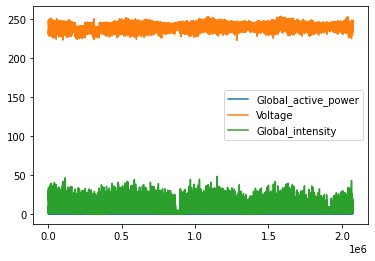

In [7]:
data[[ "Voltage", "Global_intensity"]].plot()

<AxesSubplot:>

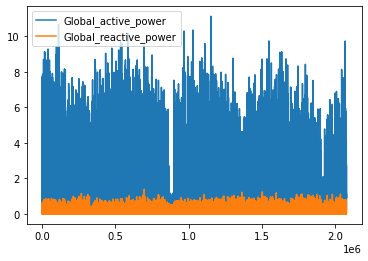

In [8]:
data[["Global_active_power", "Global_reactive_power"]].plot()

Kolko NaN hodnot:

In [9]:
data.isna().sum()

date                         0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

Korelacia dat:

In [10]:
data.corr()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Global_active_power,1.000000,0.247017,-0.399762,0.998889,0.484401,0.434569,0.638555
Global_reactive_power,0.247017,1.000000,-0.112246,0.266120,0.123111,0.139231,0.089617
Voltage,-0.399762,-0.112246,1.000000,-0.411363,-0.195976,-0.167405,-0.268172
Global_intensity,0.998889,0.266120,-0.411363,1.000000,0.489298,0.440347,0.626543
Sub_metering_1,0.484401,0.123111,-0.195976,0.489298,1.000000,0.054721,0.102571
Sub_metering_2,0.434569,0.139231,-0.167405,0.440347,0.054721,1.000000,0.080872
Sub_metering_3,0.638555,0.089617,-0.268172,0.626543,0.102571,0.080872,1.000000


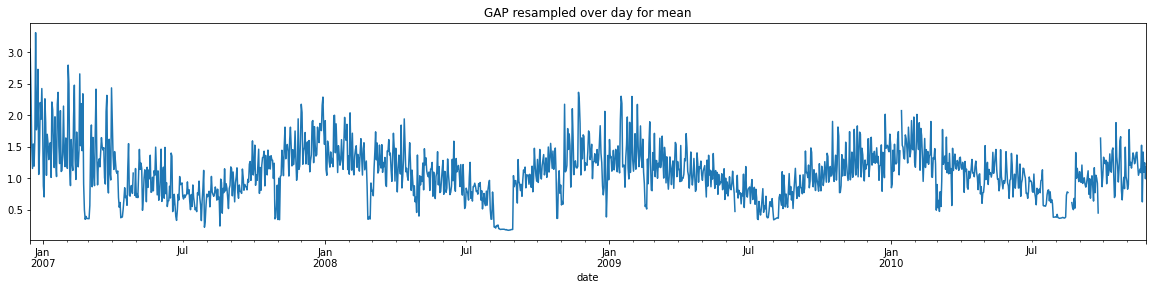

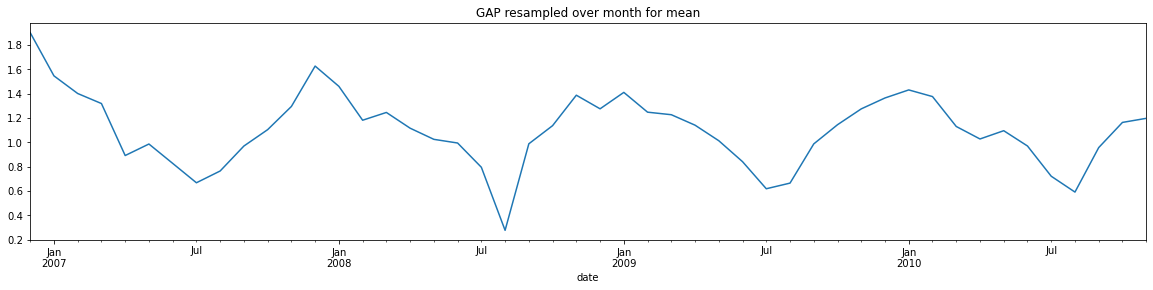

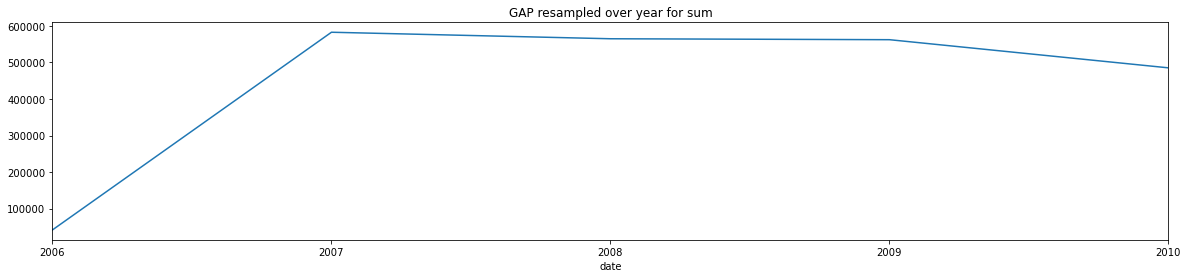

In [53]:
fig = plt.figure(figsize=(20, 4))
data.Global_active_power.resample('D').mean().plot(title="GAP resampled over day for mean")
plt.show()

fig = plt.figure(figsize=(20, 4))
data.Global_active_power.resample('M').mean().plot(title="GAP resampled over month for mean")
plt.show()

fig = plt.figure(figsize=(20, 4))
data.Global_active_power.resample('Y').sum().plot(title="GAP resampled over year for sum")
plt.show()

## Outliers

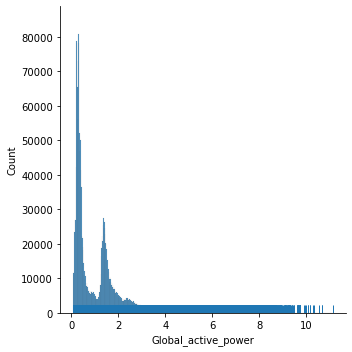

In [9]:
sns.displot(data['Global_active_power'], rug=True)

<AxesSubplot:xlabel='Global_active_power'>

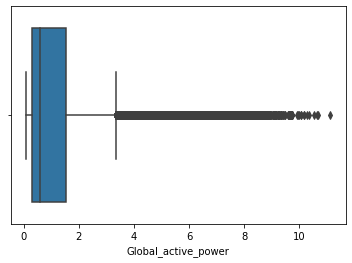

In [10]:
sns.boxplot(x=data['Global_active_power'])

<AxesSubplot:xlabel='Voltage'>

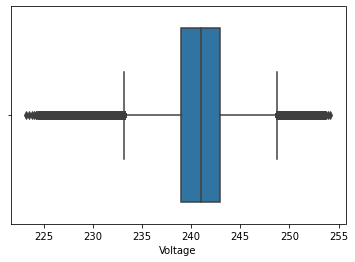

In [11]:
sns.boxplot(x=data['Voltage'])

In [12]:
for i in data.columns:
    print(i + ':')
    outliers = data[i][np.abs(data[i] - np.mean(data[i])) > 3 * np.std(data[i])]
    sorted(outliers)
    print(outliers)

date:
Series([], Name: date, dtype: datetime64[ns])
Global_active_power:
1          5.360
2          5.374
3          5.388
10         4.448
11         5.412
           ...  
2073021    4.340
2073022    4.318
2073026    4.284
2073027    4.440
2073028    4.302
Name: Global_active_power, Length: 36160, dtype: float64
Global_reactive_power:
2          0.498
3          0.502
4          0.528
5          0.522
6          0.520
           ...  
2074892    0.674
2074893    0.696
2074894    0.692
2074895    0.690
2074896    0.696
Name: Global_reactive_power, Length: 24480, dtype: float64
Voltage:
21         230.98
1422       230.94
1529       231.06
1530       230.35
1531       229.85
            ...  
2072398    230.97
2072403    230.58
2072404    230.79
2072405    230.74
2072406    231.02
Name: Voltage, Length: 12759, dtype: float64
Global_intensity:
0          18.4
1          23.0
2          23.0
3          23.0
10         19.6
           ... 
2073022    18.2
2073026    18.0
2073027    18.6
